In [1]:
import sys
sys.path.append('..')

from random import choice
from itertools import permutations

import pandas as pd
import networkx as nx

import socnet as sn
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
# sn.node_size = 10
# sn.node_color = (255, 255, 255)

# sn.edge_width = 1
# sn.edge_color = (192, 192, 192)

# sn.node_label_position = 'top center'

In [3]:
one_mode = sn.load_graph('one-mode.gml')

# sn.show_graph(one_mode, nlab=True)

In [4]:
two_mode = sn.load_graph('two-mode.gml')

graph_teste = two_mode.copy()

# sn.show_graph(two_mode, nlab=True)

In [5]:
def naming(graph):
    outd = graph.out_degree
    for i in range(len(outd)):
        if(outd[i] > 0):
            graph.nodes[i]["type"] = "people"
        else:
            graph.nodes[i]["type"] = "genre"
    return graph
            
def colocando_indegree_nos_genres(graph):
    ind = graph.in_degree
    for i in range(len(ind)):
        if(graph.nodes[i]["type"] == "genre"):
            graph.nodes[i]["value"] = ind[i]
        else:
            graph.nodes[i]["value"] = 0
            
    return graph

def ponderations_graph_degree_e_out(graph):
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "people":
            node = graph.nodes[i]
            soma = 0
            for j in range(len(list(graph.successors(i)))):
                soma +=graph.nodes[list(graph.successors(i))[j]]["value"]
            node["value"] = soma
    return graph

def ponderations_graph_degree_e_in(graph):
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "genre":
            node = graph.nodes[i]
            soma = 0
            for j in range(len(list(graph.predecessors(i)))):
                soma +=graph.nodes[list(graph.predecessors(i))[j]]["value"]
            node["value"] = soma
    return graph

def normalize_genres(graph):
    soma = 0
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "genre":
            node = graph.nodes[i]
            soma += node["value"]
            
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "genre":
            node = graph.nodes[i]
            node["value"]/= soma
    return graph


def normalize_people(graph):
    soma = 0
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "people":
            node = graph.nodes[i]
            soma += node["value"]
            
    for i in range(len(graph.nodes)):
        if graph.nodes[i]["type"] == "people":
            node = graph.nodes[i]
            node["value"]/= soma
    return graph

def euclidian_distance(c1, c2):
    return sum([(c1.nodes[i]["value"] - c2.nodes[i]["value"])** 2 for i in range(len(c1.nodes))]) ** 0.5

def ping_pong(graph):
    p_in = ponderations_graph_degree_e_in(graph)
    normal_genres = normalize_genres(p_in)
    p_out2 = ponderations_graph_degree_e_out(normal_genres)
    normal_people = normalize_people(p_out2)
    return normal_people

def hub_authority(graph):
    graph = naming(graph)
    graph = colocando_indegree_nos_genres(graph)
    graph = ponderations_graph_degree_e_out(graph)
    graph = ping_pong(graph)
    delta = 1
    epsilon = 10**-7
    while delta > epsilon:
        old = graph.copy()
        graph = ping_pong(graph)
        delta = euclidian_distance(old, graph)
#         print(delta)
    return graph
    
    

In [6]:
two_mode = hub_authority(two_mode)


In [7]:
a = [(two_mode.nodes[i]["label"], two_mode.nodes[i]["value"]) for i in range(len(two_mode.nodes)) if two_mode.nodes[i]["type"] == "people"]
sorted_list_a = sorted(a, key=lambda x: x[1], reverse=True)

In [8]:
sorted_list_a

[('Forba', 0.09457816590696895),
 ('Jean', 0.06977050807137243),
 ('Sabrina', 0.06845099493468296),
 ('Toyama', 0.05998836376053969),
 ('Rachel', 0.054038701924490534),
 ('Vitoria', 0.05374646506759368),
 ('Hugo', 0.051296027897833926),
 ('Isa', 0.0505236432020694),
 ('Graicer', 0.047239753047793424),
 ('Joao', 0.04671768652160925),
 ('Fred', 0.04441964541922752),
 ('Chen', 0.04399732976736969),
 ('Pedro', 0.041991616929317244),
 ('Martim', 0.0409756908759953),
 ('Rapha', 0.03859533919112839),
 ('Gabs', 0.03859533919112839),
 ('Ale', 0.03836720159298758),
 ('Bruna', 0.030140128945583128),
 ('Antonio', 0.024276722045354852),
 ('Paulo', 0.021207559139054147),
 ('Carlos', 0.020477001475570637),
 ('Elisa', 0.015443362733362146),
 ('Leo', 0.005162752358966937)]

In [9]:
b = [(one_mode.nodes[i]["label"], one_mode.in_degree[i]) for i in range(len(one_mode.nodes))]
sorted_list_b = sorted(b, key=lambda x: x[1], reverse=True)

In [10]:
sorted_list_b

[('Hugo', 12),
 ('Graicer', 10),
 ('Fred', 7),
 ('Toyama', 7),
 ('Forba', 7),
 ('Chen', 6),
 ('Rachel', 5),
 ('Vitoria', 5),
 ('Rapha', 3),
 ('Antonio', 3),
 ('Isa', 3),
 ('Leo', 2),
 ('Gabs', 2),
 ('Elisa', 2),
 ('Sabrina', 2),
 ('Rios', 2),
 ('Martim', 2),
 ('Jean', 1),
 ('Bruna', 1),
 ('Carlos', 1),
 ('Joao', 0),
 ('Paulo', 0),
 ('Ale', 0),
 ('Pedro', 0),
 ('Tirta', 0)]

In [11]:
# pt = soma([hub/numero_de_pessoas_recomendadas]) * seu_hub

list_final = []
for i in range(len(sorted_list_a)):
    label = sorted_list_a[i][0]
    valor1 = sorted_list_a[i][1]
    for j in range(len(sorted_list_b)):
        if(label in sorted_list_b[j]):
            valor2 = sorted_list_b[j][1]
    list_final.append((label, (valor1 * valor2) + valor1))
list_final
    

[('Forba', 0.7566253272557516),
 ('Jean', 0.13954101614274486),
 ('Sabrina', 0.20535298480404887),
 ('Toyama', 0.4799069100843175),
 ('Rachel', 0.32423221154694326),
 ('Vitoria', 0.3224787904055621),
 ('Hugo', 0.666848362671841),
 ('Isa', 0.2020945728082776),
 ('Graicer', 0.5196372835257277),
 ('Joao', 0.04671768652160925),
 ('Fred', 0.35535716335382017),
 ('Chen', 0.3079813083715878),
 ('Pedro', 0.041991616929317244),
 ('Martim', 0.1229270726279859),
 ('Rapha', 0.15438135676451356),
 ('Gabs', 0.11578601757338516),
 ('Ale', 0.03836720159298758),
 ('Bruna', 0.060280257891166256),
 ('Antonio', 0.09710688818141941),
 ('Paulo', 0.021207559139054147),
 ('Carlos', 0.04095400295114127),
 ('Elisa', 0.04633008820008644),
 ('Leo', 0.015488257076900812)]

In [12]:
list_final_sorted = sorted(list_final, key=lambda x: x[1], reverse=True)
list_final_sorted

[('Forba', 0.7566253272557516),
 ('Hugo', 0.666848362671841),
 ('Graicer', 0.5196372835257277),
 ('Toyama', 0.4799069100843175),
 ('Fred', 0.35535716335382017),
 ('Rachel', 0.32423221154694326),
 ('Vitoria', 0.3224787904055621),
 ('Chen', 0.3079813083715878),
 ('Sabrina', 0.20535298480404887),
 ('Isa', 0.2020945728082776),
 ('Rapha', 0.15438135676451356),
 ('Jean', 0.13954101614274486),
 ('Martim', 0.1229270726279859),
 ('Gabs', 0.11578601757338516),
 ('Antonio', 0.09710688818141941),
 ('Bruna', 0.060280257891166256),
 ('Joao', 0.04671768652160925),
 ('Elisa', 0.04633008820008644),
 ('Pedro', 0.041991616929317244),
 ('Carlos', 0.04095400295114127),
 ('Ale', 0.03836720159298758),
 ('Paulo', 0.021207559139054147),
 ('Leo', 0.015488257076900812)]

## Teste de Hipótese

H1 => Se um aluno gosta de estilos mais gostados pela classe (tem um alto valor de hub no hub-authority), ela recebera mais votos


In [16]:
from scipy.stats import ttest_ind, ttest_rel, linregress


list_final_testx = []
list_final_testy = []
for i in range(len(sorted_list_a)):
    label = sorted_list_a[i][0]
    valor1 = sorted_list_a[i][1]
    for j in range(len(sorted_list_b)):
        if(label in sorted_list_b[j]):
            valor2 = sorted_list_b[j][1]
    list_final_testx.append(valor2)
    list_final_testy.append(valor1)


In [17]:

# Train the model using the training sets
l = linregress(list_final_testx, list_final_testy)

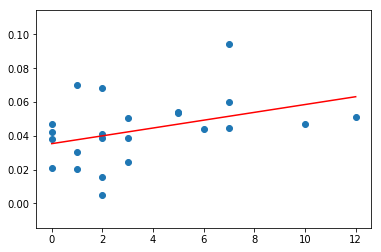

In [18]:
plt.scatter(list_final_testx, list_final_testy)
plt.plot(range(13), range(13)*l.slope + l.intercept, 'r')
plt.show()

In [19]:
print(f'P-value: {l.pvalue}')

P-value: 0.06470282839467


Fazendo a regressão linear com os valores hub e indicação (indegree) de cada aluno, percebe-se uma relação de crescimento, porém como o p-valor é maior que 5%, a hipótese nula (que não há relação entre as duas medidas) não pode ser rejeitada. Todavia, como o p-value é muito próximo de 5%, não podemos tirar uma conclusão rígida.

## Método 2

In [20]:
graph_teste = hub_authority(graph_teste)
a2 = [[graph_teste.nodes[i]["label"], (graph_teste.nodes[i]["value"])/graph_teste.out_degree[i]] for i in range(len(graph_teste.nodes)) if graph_teste.nodes[i]["type"] == "people"]
sorted_list_a2 = sorted(a2, key=lambda x: x[1], reverse=True)

In [21]:
soma = 0

for i in range(len(sorted_list_a2)):
    soma += sorted_list_a2[i][1]
    

for i in range(len(sorted_list_a2)):
    sorted_list_a2[i][1] /= soma



In [22]:
list_final2 = []
for i in range(len(sorted_list_a2)):
    label = sorted_list_a2[i][0]
    valor1 = sorted_list_a2[i][1]
    for j in range(len(sorted_list_b)):
        if(label in sorted_list_b[j]):
            valor2 = sorted_list_b[j][1]
    list_final2.append((label, (valor1 * valor2) + valor1))    

In [23]:
list_final_sorted2 = sorted(list_final2, key=lambda x: x[1], reverse=True)
list_final_sorted2

[('Hugo', 0.5673308883072609),
 ('Graicer', 0.5157704227672844),
 ('Toyama', 0.3572517760230266),
 ('Chen', 0.30568947737055624),
 ('Fred', 0.3023252457936706),
 ('Forba', 0.3003979716523267),
 ('Rachel', 0.275845242924104),
 ('Vitoria', 0.274353494530615),
 ('Rapha', 0.18387904063903326),
 ('Isa', 0.17193488044870328),
 ('Martim', 0.1464147786826198),
 ('Elisa', 0.13795597391899453),
 ('Gabs', 0.13790928047927495),
 ('Sabrina', 0.12229491510340876),
 ('Carlos', 0.12194773596385104),
 ('Antonio', 0.1156611252320959),
 ('Leo', 0.09223801086342959),
 ('Bruna', 0.08974752702336193),
 ('Jean', 0.08310157623909982),
 ('Pedro', 0.050014965522180814),
 ('Joao', 0.04637003866326091),
 ('Paulo', 0.04209948781502544),
 ('Ale', 0.03808169354544222)]

In [24]:
list_final_testx2 = []
list_final_testy2 = []
for i in range(len(sorted_list_a2)):
    label = sorted_list_a2[i][0]
    valor1 = sorted_list_a2[i][1]
    for j in range(len(sorted_list_b)):
        if(label in sorted_list_b[j]):
            valor2 = sorted_list_b[j][1]
    list_final_testx2.append(valor2)
    list_final_testy2.append(valor1)    

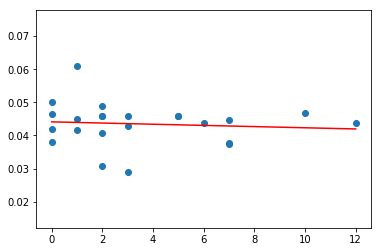

In [27]:

# Train the model using the training sets
l = linregress(list_final_testx2, list_final_testy2)

plt.scatter(list_final_testx2, list_final_testy2)
plt.plot(range(13), range(13)*l.slope + l.intercept, 'r')
plt.show()

In [28]:
print(f'P-value: {l.pvalue}')

P-value: 0.6772740571481561


## Comparação

In [29]:
list_final_sorted

[('Forba', 0.7566253272557516),
 ('Hugo', 0.666848362671841),
 ('Graicer', 0.5196372835257277),
 ('Toyama', 0.4799069100843175),
 ('Fred', 0.35535716335382017),
 ('Rachel', 0.32423221154694326),
 ('Vitoria', 0.3224787904055621),
 ('Chen', 0.3079813083715878),
 ('Sabrina', 0.20535298480404887),
 ('Isa', 0.2020945728082776),
 ('Rapha', 0.15438135676451356),
 ('Jean', 0.13954101614274486),
 ('Martim', 0.1229270726279859),
 ('Gabs', 0.11578601757338516),
 ('Antonio', 0.09710688818141941),
 ('Bruna', 0.060280257891166256),
 ('Joao', 0.04671768652160925),
 ('Elisa', 0.04633008820008644),
 ('Pedro', 0.041991616929317244),
 ('Carlos', 0.04095400295114127),
 ('Ale', 0.03836720159298758),
 ('Paulo', 0.021207559139054147),
 ('Leo', 0.015488257076900812)]

In [30]:
list_final_sorted2

[('Hugo', 0.5673308883072609),
 ('Graicer', 0.5157704227672844),
 ('Toyama', 0.3572517760230266),
 ('Chen', 0.30568947737055624),
 ('Fred', 0.3023252457936706),
 ('Forba', 0.3003979716523267),
 ('Rachel', 0.275845242924104),
 ('Vitoria', 0.274353494530615),
 ('Rapha', 0.18387904063903326),
 ('Isa', 0.17193488044870328),
 ('Martim', 0.1464147786826198),
 ('Elisa', 0.13795597391899453),
 ('Gabs', 0.13790928047927495),
 ('Sabrina', 0.12229491510340876),
 ('Carlos', 0.12194773596385104),
 ('Antonio', 0.1156611252320959),
 ('Leo', 0.09223801086342959),
 ('Bruna', 0.08974752702336193),
 ('Jean', 0.08310157623909982),
 ('Pedro', 0.050014965522180814),
 ('Joao', 0.04637003866326091),
 ('Paulo', 0.04209948781502544),
 ('Ale', 0.03808169354544222)]

In [31]:
for i in range(len(one_mode.nodes)):
    print(one_mode.nodes[i])

{'label': 'Rachel', 'color': (255, 255, 255), 'pos': (0.9199456350995449, 0.3301762354100153)}
{'label': 'Jean', 'color': (255, 255, 255), 'pos': (1.0, 0.48378859160088067)}
{'label': 'Bruna', 'color': (255, 255, 255), 'pos': (0.6597946658227088, 0.6060933380762026)}
{'label': 'Leo', 'color': (255, 255, 255), 'pos': (0.8564201490208788, 0.34899107009583086)}
{'label': 'Joao', 'color': (255, 255, 255), 'pos': (0.8302494742863075, 0.5039056781303795)}
{'label': 'Rapha', 'color': (255, 255, 255), 'pos': (0.9566052390161917, 0.6438622747231005)}
{'label': 'Carlos', 'color': (255, 255, 255), 'pos': (0.597391276645875, 0.6789213501853985)}
{'label': 'Fred', 'color': (255, 255, 255), 'pos': (0.9172691250248296, 0.5355998464681654)}
{'label': 'Toyama', 'color': (255, 255, 255), 'pos': (0.9819168461881859, 0.5373747412876968)}
{'label': 'Vitoria', 'color': (255, 255, 255), 'pos': (0.7586536325009647, 0.5386140952769176)}
{'label': 'Hugo', 'color': (255, 255, 255), 'pos': (0.8839742914313747, 0.